<a href="https://colab.research.google.com/github/pyrovelocity/tctsti/blob/main/docs/notebooks/nsde_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Stochastic Differential Equations (SDEs) model latent representations of nacent and mature mRNA kinetics

NOTE: If running this notebook please use runtime w/ GPU


In [ ]:
%pip install torchsde
%pip install pykeops
%pip install scanpy
%pip install scvelo
%pip install anndata
%pip install geomloss
%pip install pytorch_lightning
%pip install umap-learn
%pip install timm
%pip install igraph
%pip install louvain

In [2]:
import numpy as np
import anndata
import scanpy as sc
import scvelo as scv
import torch
import torchsde
from torchsde import BrownianInterval
from urllib import request
import torch
from torch import nn
from geomloss import SamplesLoss
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import umap
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import ProgressBar, StochasticWeightAveraging
from timm.scheduler import TanhLRScheduler

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


Our lightning model will take a a few different torch.nn.Modules as inputs. We have our SDE model (a drift + diffusion field) and an autoencoder module. Before I had the regularization model, but let's try without that and just do the drift with the "reaction kinetics" form

We begin with the autoencoder. We will have two encoder functions $\phi_u$ and $\phi(s)$ that map unspliced and spliced counts to our "latent spliced" and "latent unspliced" features $z_u$ and $z_s$ respectively. Then there will be decoders that can map them back i.e. $ u = \phi_u(z_u)$, $s = \phi_s(z_s)$. I haven't explored different architectures for these, but maybe we can just copy whatever scVI does.

In [3]:
class autoencoder(torch.nn.Module):
    def __init__(self, num_genes, latent_pairs):
        super().__init__()

        self.num_genes = num_genes
        self.latent_pairs = latent_pairs

        self.encoder_u = torch.nn.Sequential(
            nn.Linear(num_genes, int(num_genes / 2)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 2), int(num_genes / 4)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 4), int(num_genes / 8)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 8), int(num_genes / 32)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 32), latent_pairs),
        )

        self.encoder_s = torch.nn.Sequential(
            nn.Linear(num_genes, int(num_genes / 2)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 2), int(num_genes / 4)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 4), int(num_genes / 8)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 8), int(num_genes / 32)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 32), latent_pairs),
        )

        self.decoder_u = torch.nn.Sequential(
            nn.Linear(latent_pairs, int(num_genes / 32)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 32), int(num_genes / 16)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 16), int(num_genes / 8)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 8), int(num_genes / 2)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 2), num_genes),
        )

        self.decoder_s = torch.nn.Sequential(
            nn.Linear(latent_pairs, int(num_genes / 32)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 32), int(num_genes / 16)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 16), int(num_genes / 8)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 8), int(num_genes / 2)),
            nn.LeakyReLU(),
            nn.Linear(int(num_genes / 2), num_genes),
        )

Now this is really the core of the model, how the SDE's drift field is defined. We really want to explore what $\alpha(z_u, z_s)$ is doing, so let's define the parameterization the drift field with $\alpha(z_u, z_s)$. We can always modify *alpha_fn* to take any form, but let's start with just a deep neural network

In [4]:
class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self, latent_pairs):
        super().__init__()

        self.N = latent_pairs

        # note that the alpha doesn't care what is "unspliced" vs "spliced"
        # latent variables for now. it maps vector in 2*latent_pairs to
        # vector in 1*latent_pairs
        self.alpha_fn = torch.nn.Sequential(
            nn.Linear(self.N * 2, int(self.N * 1.5)),
            nn.Tanh(),
            nn.Linear(int(self.N * 1.5), int(self.N * 1.25)),
            nn.Tanh(),
            nn.Linear(int(self.N * 1.25), self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Softplus(),
        )

        # beta (splicing rate) will be a function of just unspliced variables
        # although maybe this isn't the right assumption?
        self.beta_fn = torch.nn.Sequential(
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Softplus(),
        )

        # gamma (degredation rate) will be a function of just unspliced variables
        self.gamma_fn = torch.nn.Sequential(
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Tanh(),
            nn.Linear(self.N, self.N),
            nn.Softplus(),
        )

        # keep sigma simple for now
        self.sigma = torch.nn.Sequential(nn.Linear(int(self.N * 2), int(self.N * 2)))

    # unregularized drift
    def f(self, t, y):
        u = y[:, : self.N]
        s = y[:, self.N :]
        drift_u = self.alpha_fn(y) - self.beta_fn(u)
        drift_s = self.beta_fn(u) - self.gamma_fn(s)

        return torch.cat((drift_u, drift_s), dim=1).float()  # shape (batch_size, state_size)

    # could we start with constant diffusion and scale it up?
    # diffusion field
    def g(self, t, y):
        return self.sigma(y).float()

In [5]:
class light_module(pl.LightningModule):
    def __init__(self, initial_cells, SDE, autoencoder, n_integrations=100, lr=0.0001):
        super().__init__()
        cuda = torch.device('cuda')

        self.training_phase = 0
        self.autoencoder = autoencoder.to(device=cuda)
        self.sde = SDE.to(device=cuda)

        self.ot_loss_fn = SamplesLoss(loss='sinkhorn', p=2, blur=2, backend='tensorized')
        self.softmax = nn.Softmax(dim=1)
        self.mse_loss_fn = torch.nn.MSELoss()

        self.initial_cells = torch.from_numpy(initial_cells)
        self.X0 = torch.from_numpy(initial_cells).float().to(device=cuda).float()
        self.n_integrations = n_integrations
        self.t_fwd = torch.from_numpy(np.linspace(0, 1, 60)).to(device=cuda)
        self.delta_t = float(1) / float(60)
        self.lr = lr
        self.ot_loss_history = []
        self.vae_recon_loss_history = []
        self.grad_norm_hist = []
        self.latent_pairs = autoencoder.latent_pairs
        self.n_genes = autoencoder.num_genes

        cuda = torch.device('cuda')

    def _initialize_weights(self):
        for m in self.sde.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        for m in self.autoencoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        # in the first training phase we can just fit the autoencoder
        if self.training_phase == 0:
            cuda = torch.device('cuda')

            U, S = batch[:, 0 : self.n_genes], batch[:, self.n_genes :]
            Z_U, Z_S = self.autoencoder.encoder_u(U), self.autoencoder.encoder_s(S)
            X_U, X_S = self.autoencoder.decoder_u(Z_U), self.autoencoder.decoder_s(Z_S)
            X_recon = torch.cat((X_U, X_S), dim=1)
            loss = self.mse_loss_fn(X_recon, batch) * self.n_genes

            self.log("pretraining_loss", loss, on_step=True, prog_bar=True)

            return loss

        # in the second training phase we learn the SDE
        if self.training_phase != 0:
            X0_samp_idxs = np.random.choice(self.X0.shape[0], self.n_integrations)
            self.X0_samp = self.X0[X0_samp_idxs, :]

            cuda = torch.device('cuda')

            U, S = batch[:, 0 : self.n_genes], batch[:, self.n_genes :]
            Z_U, Z_S = self.autoencoder.encoder_u(U), self.autoencoder.encoder_s(S)
            X_U, X_S = self.autoencoder.decoder_u(Z_U), self.autoencoder.decoder_s(Z_S)
            X_recon = torch.cat((X_U, X_S), dim=1)
            vae_recon_loss = self.mse_loss_fn(X_recon, batch) * self.n_genes

            X0_ = self.X0_samp
            U0, S0 = X0_[:, : self.n_genes], X0_[:, self.n_genes :]
            Z_U0, Z_S0 = (
                self.autoencoder.encoder_u(U0).to(device=cuda).float(),
                self.autoencoder.encoder_s(S0).to(device=cuda).float(),
            )

            U0_recon, S0_recon = self.autoencoder.decoder_u(Z_U0), self.autoencoder.decoder_s(Z_S0)
            X0_recon = torch.cat((U0_recon, S0_recon), dim=1)
            initial_pos_loss = self.mse_loss_fn(X0_recon, X0_) * self.n_genes

            Z0_ = torch.cat((Z_U0, Z_S0), dim=1)
            self.Z0_ = Z0_

            Z_pred = torchsde.sdeint(self.sde, Z0_, self.t_fwd, method='euler')

            Z_pred_flat = torch.flatten(Z_pred, start_dim=0, end_dim=1)

            U_fwd, S_fwd = Z_pred_flat[:, : self.latent_pairs], Z_pred_flat[:, self.latent_pairs :]
            X_U_fwd, X_S_fwd = self.autoencoder.decoder_u(U_fwd), self.autoencoder.decoder_s(S_fwd)
            X_fwd = torch.cat((X_U_fwd, X_S_fwd), dim=1)

            ot_loss = self.ot_loss_fn(X_fwd, batch)
            loss = ot_loss + vae_recon_loss + initial_pos_loss

            self.ot_loss_history.append(ot_loss.cpu().detach().numpy())
            self.vae_recon_loss_history.append(vae_recon_loss.cpu().detach().numpy())
            self.log("transport_loss", ot_loss, on_step=True, prog_bar=True)
            self.log("recon_loss", vae_recon_loss, on_step=True, prog_bar=True)
            self.log("initial_loss", initial_pos_loss, on_step=True, prog_bar=True)

            return loss

    def configure_optimizers(self):
        parameters = [{'params': self.parameters(), 'lr': self.lr}]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        return optimizer

    def on_after_backward(self):
        # Custom gradient clipping
        torch.nn.utils.clip_grad_norm_(self.parameters(), 10)

        # Now compute and log the global grad norm
        grad_norm = 0.0
        for name, param in self.named_parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2).item() ** 2
                grad_norm += param_norm

        grad_norm = grad_norm ** (1.0 / 2)
        self.grad_norm_hist.append(grad_norm)

In [6]:
# dataset class
class dataset_(Dataset):
    def __init__(self, X):
        self.cuda = torch.device('cuda')
        self.X = torch.from_numpy(X).float().to(device=self.cuda)

    def __len__(self):
        return self.X.size(dim=0)

    def __getitem__(self, idx):
        return self.X[idx, :]

In [7]:
# load the pancreas dataset
adata = scv.datasets.pancreas()
adata

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [8]:
scv.pp.normalize_per_cell(adata, counts_per_cell_after=1000)  ### I need to think about the preprocessing a lot more.
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)

Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.


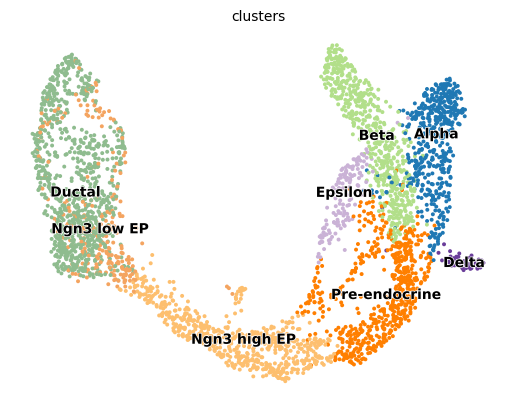

In [9]:
scv.pl.umap(adata)

I need to choose an initial population, let's choose the cells with the highest S_score in the cycling progenitors. (ideally I'd like to have an option to automate the selection of initial cells, although I think using our own knowledge of the biological system is important in real applications)

/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


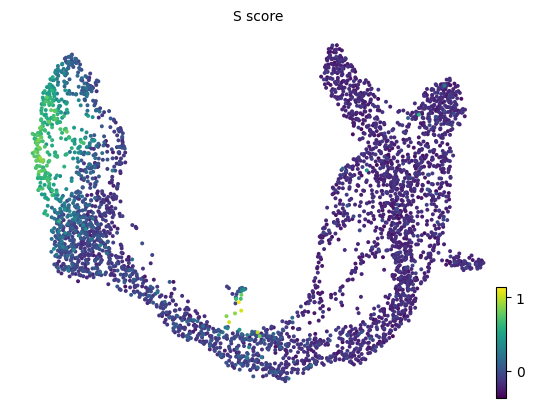

In [10]:
scv.pl.umap(adata, color='S_score')

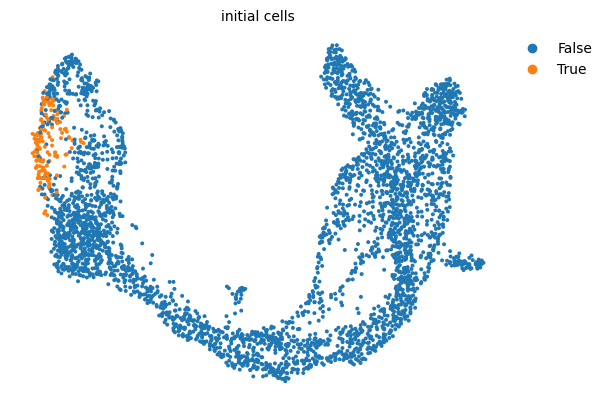

In [11]:
adata.obs['initial_cells'] = (adata.obs['S_score'] >= adata.obs['S_score'].quantile(0.95)) & (
    adata.obs['clusters'] == 'Ductal'
)
scv.pl.umap(adata, color='initial_cells')

In [12]:
X = np.concatenate((adata.layers['unspliced'].todense(), adata.layers['spliced'].todense()), axis=1)
dataset = dataset_(X)
batch_size = 2000
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X0 = np.concatenate(
    (
        adata.layers['unspliced'][adata.obs['initial_cells'] == 'True', :].todense(),
        adata.layers['spliced'][adata.obs['initial_cells'] == 'True', :].todense(),
    ),
    axis=1,
)

In [ ]:
# n_latent_variables = 30

# sde = SDE(n_latent_variables)
# module.sde = sde.to(device="cuda")

In [16]:
n_latent_variables = 30

sde = SDE(n_latent_variables)
ae = autoencoder(3000, n_latent_variables)

module = light_module(X0, sde, ae, n_integrations=100, lr=0.0001)
module.training_phase = 0
trainer = pl.Trainer(
    callbacks=[StochasticWeightAveraging(swa_lrs=1e-3)],
    accumulate_grad_batches=1,
    max_epochs=300,
    enable_progress_bar=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
module.lr = 0.001  # learning rate can be high for the VAE pretraining relative to the learning rate for the full model
module.training_phase = 0
trainer.fit(module, dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type        | Params
--------------------------------------------
0 | autoencoder | autoencoder | 22.2 M
1 | sde         | SDE         | 20.4 K
2 | ot_loss_fn  | SamplesLoss | 0     
3 | softmax     | Softmax     | 0     
4 | mse_loss_fn | MSELoss     | 0     
--------------------------------------------
22.2 M    Trainable params
0         Non-trainable params
22.2 M    Total params
88.919    Total estimated mode

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


In [18]:
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=True)
module.lr = 0.00005
module.training_phase = 1
trainer.fit(module, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type        | Params
--------------------------------------------
0 | autoencoder | autoencoder | 22.2 M
1 | sde         | SDE         | 20.4 K
2 | ot_loss_fn  | SamplesLoss | 0     
3 | softmax     | Softmax     | 0     
4 | mse_loss_fn | MSELoss     | 0     
--------------------------------------------
22.2 M    Trainable params
0         Non-trainable params
22.2 M    Total params
88.919    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


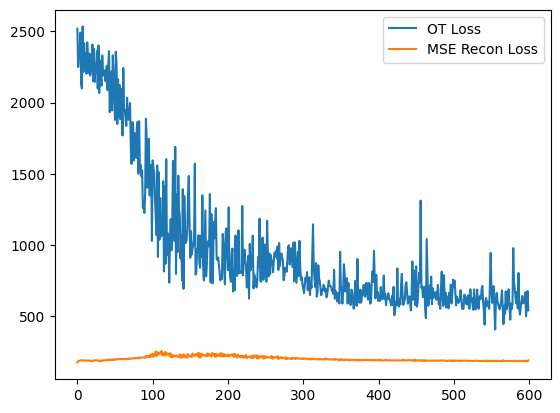

In [19]:
plt.plot(module.ot_loss_history, label='OT Loss')
plt.plot(module.vae_recon_loss_history, label='MSE Recon Loss')

plt.legend()
plt.show()